In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import os
from glob import glob

In [16]:
train_images=[]
train_labels=[]

In [17]:
rock=glob("C:/priyanshu's PC/project rps/data/training/rock"+"/*")
paper=glob("C:/priyanshu's PC/project rps/data/training/paper"+"/*")
scissors=glob("C:/priyanshu's PC/project rps/data/training/scissors"+"/*")

In [18]:
len(rock)

606

In [19]:
import cv2
for label,img_paths in zip([0,1,2],[rock,paper,scissors]):
    for img_path in img_paths:
        image = cv2.imread(img_path)
        image=cv2.resize(image,(256,256))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #also try with rgb
        train_images.append(image)
        train_labels.append(label)

In [20]:
#cv2.imshow('rock',train_images[0])

In [21]:
x_train=np.array(train_images)
y_train=np.array(train_labels)

In [22]:
x_train.shape

(1671, 256, 256, 3)

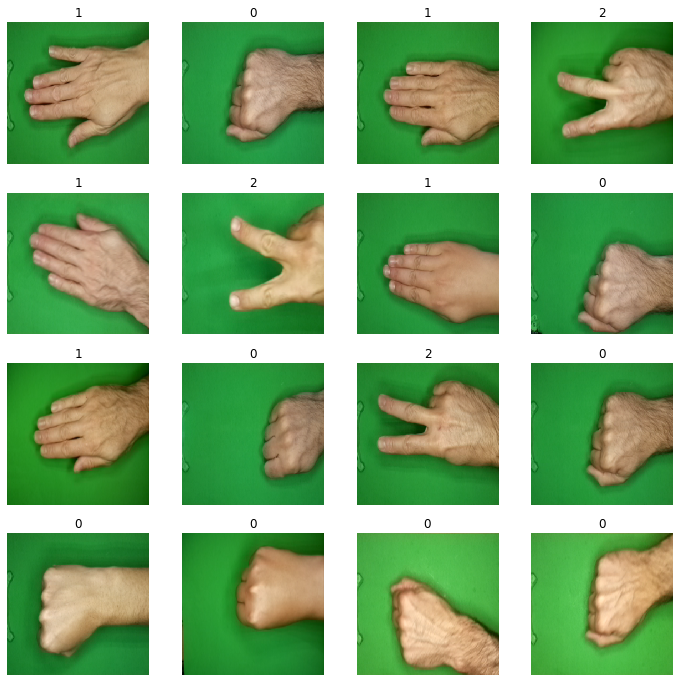

In [23]:
import matplotlib.pyplot as plt
import random
figure = plt.figure(figsize=(12,12))

for i in range(0,16):
    random_image = random.randint(0,len(x_train))
    figure.add_subplot(4,4,i+1)
    plt.imshow(x_train[random_image])
    plt.axis("off")
    plt.title(y_train[random_image])

plt.show()

In [24]:
#validation data
val_images=[]
val_labels=[]

val_rock=glob("C:/priyanshu's PC/project rps/data/validation/rock"+"/*")
val_paper=glob("C:/priyanshu's PC/project rps/data/validation/paper"+"/*")
val_scissors=glob("C:/priyanshu's PC/project rps/data/validation/scissors"+"/*")

for label,img_paths in zip([0,1,2],[val_rock,val_paper,val_scissors]):
    for img_path in img_paths:
        image = cv2.imread(img_path)
        image=cv2.resize(image,(256,256))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #also try with rgb
        val_images.append(image)
        val_labels.append(label)
x_val=np.array(val_images)
y_val=np.array(val_labels)

x_val.shape

(384, 256, 256, 3)

In [25]:
import pandas as pd
encoded_labels = pd.get_dummies(pd.DataFrame(y_train),columns=[0])
print(encoded_labels.head())
encoded_labels = np.array(encoded_labels)

   0_0  0_1  0_2
0    1    0    0
1    1    0    0
2    1    0    0
3    1    0    0
4    1    0    0


In [26]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
!pip install keras-tuner

You should consider upgrading via the 'c:\users\pablo\anaconda3\python.exe -m pip install --upgrade pip' command.


In [28]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [29]:
def build_model(hp):
    model= keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(256,256,3)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [30]:
tuner_search=RandomSearch(build_model,max_trials=5,
                          objective='val_accuracy',directory='output',project_name="latest_rps_with_tuner")

In [31]:
tuner_search.search(x_train,encoded_labels,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 52m 20s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.7916666865348816
Total elapsed time: 02h 01m 41s
INFO:tensorflow:Oracle triggered exit


In [32]:
print(tuner_search.get_best_hyperparameters)

<bound method BaseTuner.get_best_hyperparameters of <kerastuner.tuners.randomsearch.RandomSearch object at 0x000001B0E91977C8>>


In [33]:
model=tuner_search.get_best_models(num_models=1)[0]

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 48)      1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      13856     
_________________________________________________________________
flatten (Flatten)            (None, 2032128)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                130056256 
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 130,071,651
Trainable params: 130,071,651
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(x_train,encoded_labels, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
47/47 [==============================] - 177s 4s/step - loss: 0.5063 - accuracy: 0.8696 - val_loss: 0.6568 - val_accuracy: 0.8036
Epoch 5/10
47/47 [==============================] - 178s 4s/step - loss: 0.3163 - accuracy: 0.9255 - val_loss: 0.5696 - val_accuracy: 0.7738
Epoch 6/10
47/47 [==============================] - 175s 4s/step - loss: 0.3133 - accuracy: 0.9268 - val_loss: 0.7242 - val_accuracy: 0.7917
Epoch 7/10
47/47 [==============================] - 176s 4s/step - loss: 0.1216 - accuracy: 0.9747 - val_loss: 1.6269 - val_accuracy: 0.7560
Epoch 8/10
47/47 [==============================] - 176s 4s/step - loss: 0.0600 - accuracy: 0.9907 - val_loss: 2.6701 - val_accuracy: 0.7560
Epoch 9/10
47/47 [==============================] - 174s 4s/step - loss: 0.0526 - accuracy: 0.9900 - val_loss: 1.7839 - val_accuracy: 0.7262
Epoch 10/10
47/47 [==============================] - 174s 4s/step - loss: 0.0292 - accuracy: 0.9967 - val_loss: 2.4540 - val_accuracy: 0.7262


In [39]:
model.save('C:/Users/Pablo/latest rps')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/Pablo/latest rps\assets


In [45]:
LABELS_INPUT = {
    0: "rock",
    1: "paper",
    2: "scissors",
    3: "noise"
}


def map_index_to_label(index):
    return LABELS_INPUT[index]

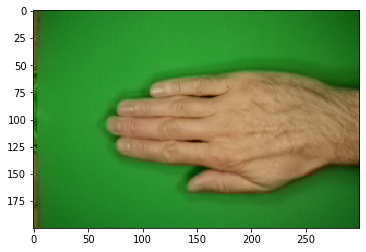

paper


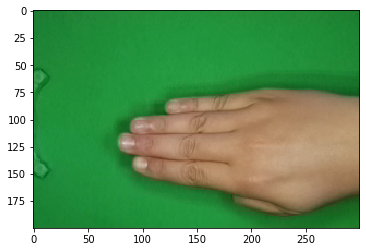

rock


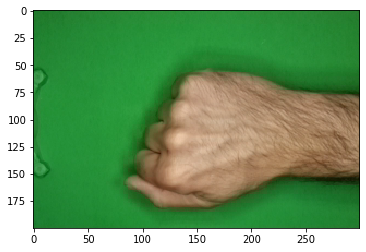

rock


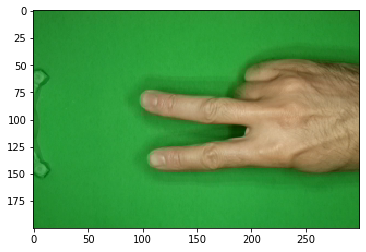

scissors


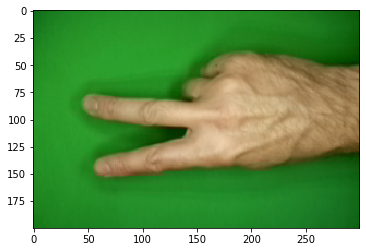

scissors


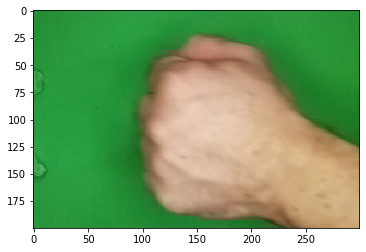

rock


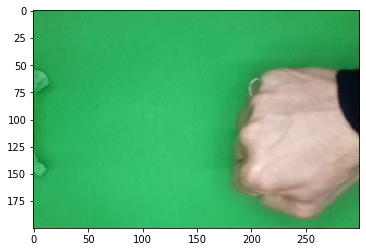

rock


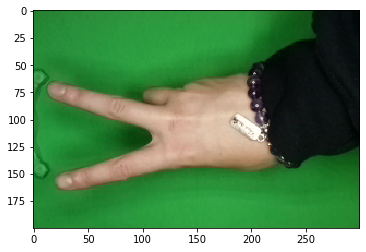

paper


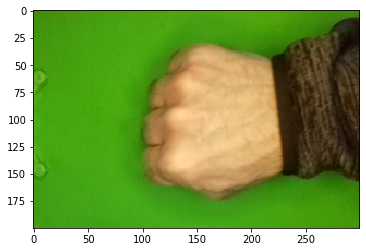

rock


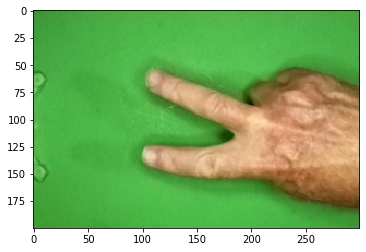

scissors


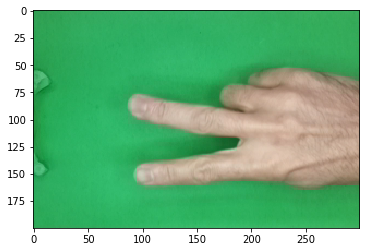

rock


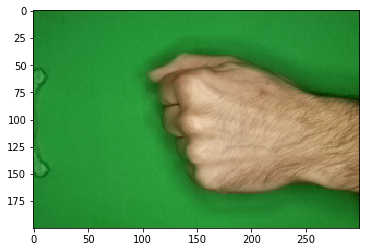

rock


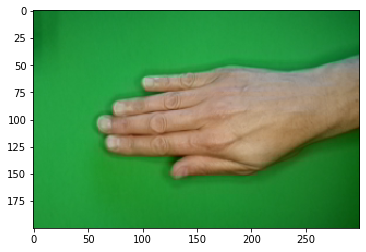

paper


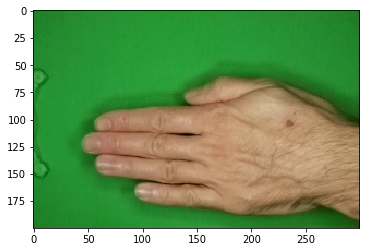

paper


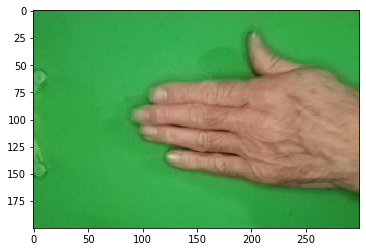

paper


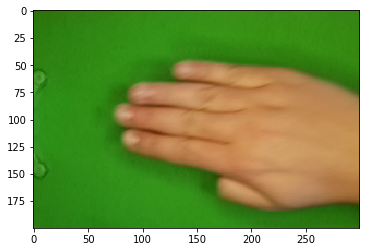

paper


In [47]:
tst=glob("C:/Users/Pablo/Desktop/test"+"/*")
for img in tst:
    image=cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(image)
    plt.show()
    image=cv2.resize(image,(256,256)) #also try with rgb
    y_test=model.predict_classes(np.array([image]))
    print(map_index_to_label(y_test[0]))
    
      

In [60]:
def play_game():
    x=random.choice([0,1,2])
    image = cv2.imread("C:/Users/Pablo/Desktop/test/3XNPuMFoaFCfRCVb.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(image)
    plt.show()
    image=cv2.resize(image,(256,256)) #also try with rgb
    y_test=model.predict_classes(np.array([image]))
    #print(np.argmax(model.predict(np.array([image])), axis=-1))
    print("your move is : ",map_index_to_label(y_test[0]))
    print("Bot move is  : ",map_index_to_label(x))
    if y_test[0]==0:
        if x==1:
            print('YOU LOOSE')
        else :
            print('YOU WON')
    elif y_test[0]==1:
        if x==2:
            print('YOU LOOSE')
        else :
            print('YOU WON')
    else :
        if x==0:
            print('YOU LOOSE')
        else :
            print('YOU WON')
            
        
      

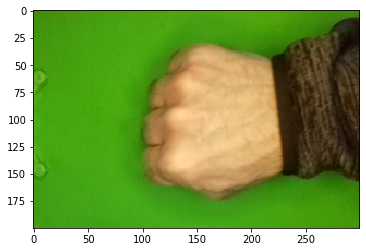

your move is :  rock
Bot move is  :  scissors
YOU WON


In [61]:
play_game()